In [2]:
%matplotlib inline
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt
import csv

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars)) # [' ', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) # {' ': 0, '+': 1, '0': 2, ... , '9': 11}
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) # {0: ' ', 1: '+', 2: '0',..., 11: '9'}
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    # f函數：隨機產生一個1位數到3位數之間的整數（DIGIT==3）
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b))) # 將a, b由小到大排序並轉成tuple
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q)) # 將query長度補足到7，MAXLEN最長等於7(當DIGIT等於3)
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans)) # 將ans長度補足到4，兩三位數相加最多是四位數
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [8]:
print(questions[:5], expected[:5])
print(len(questions))

['0+980  ', '0+562  ', '605+81 ', '13+588 ', '73+40  '] ['980 ', '562 ', '686 ', '601 ', '113 ']
80000


# Processing

In [9]:
print('Vectorization...')
# x總共有80000筆資料，每筆資料shape是7x12，7代表問題長度為7，並且每個位數的值有12種可能
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) # x.shape = (80000, 7, 12)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool) # y.shape = (80000, 4, 12)

# 將問題與解答編碼成一個一個的二維陣列
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
# 將80000筆資料打亂順序
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:60000]
train_y = y[:60000]
test_x = x[60000:]
test_y = y[60000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(54000, 7, 12)
(54000, 4, 12)
Validation Data:
(6000, 7, 12)
(6000, 4, 12)
Testing Data:
(20000, 7, 12)
(20000, 4, 12)


In [11]:
#print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

# Build Model

[keras中TimeDistributed和RepeatVector的解释](https://blog.csdn.net/ChaoFeiLi/article/details/89323078)

In [12]:
def buildModel(shape):
    model = Sequential()
    model.add(layers.LSTM(128, input_shape=(shape[1], shape[2])))
    model.add(layers.RepeatVector(DIGITS + 1))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    #model.add(layers.Lambda(lambda x: x[:, 3:, :]))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model

In [13]:
print('Build model...')
model = buildModel(x_train.shape)

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 64)             49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 64)             33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             780       
Total params: 155,404
Trainable params: 155,404
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
decode_y = []
for i in range(20000):
    decode_y.append(ctable.decode(test_y[i]))

In [15]:
epoch_prediction = []
def first_ten():
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
        
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    if iteration == 0:
        first_ten()
    pred = model.predict(test_x)
    correct = 0
    for i in range(20000):
        if ctable.decode(pred[i]) == decode_y[i]:
            correct += 1
    acc = round(correct/20000, 3)
    print('Accuracy on Testing Data:',acc)
    epoch_prediction.append(acc)
    if acc >= 0.95:
        first_ten()
        break


--------------------------------------------------
Iteration 0
Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 42s 782us/step - loss: 1.9253 - acc: 0.3104 - val_loss: 1.8201 - val_acc: 0.3394
Q 71+801  T 872  ☒ 103 
Q 33+617  T 650  ☒ 103 
Q 300+765 T 1065 ☒ 1108
Q 48+751  T 799  ☒ 103 
Q 479+943 T 1422 ☒ 1108
Q 0+445   T 445  ☒ 13  
Q 93+748  T 841  ☒ 103 
Q 493+4   T 497  ☒ 133 
Q 2+892   T 894  ☒ 133 
Q 377+37  T 414  ☒ 103 
Accuracy on Testing Data: 0.001

--------------------------------------------------
Iteration 1
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 36s 664us/step - loss: 1.7606 - acc: 0.3364 - val_loss: 1.7099 - val_acc: 0.3546
Accuracy on Testing Data: 0.001

--------------------------------------------------
Iteration 2
Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==========

In [16]:
with open('output/ex1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(epoch_prediction)

# Testing

In [17]:
print("MSG : Prediction")
cost = model.evaluate(test_x, test_y, batch_size=40)
print("test cost: {}".format(cost))
pred = model.predict(test_x)

MSG : Prediction
20000/20000 [==============================] - 8s 388us/step
test cost: [0.06851156693696976, 0.9878249961137772]


In [18]:
print('First 10 testing data:')
print('Prediction\tAnswer')
for i in range(10):
    print(ctable.decode(pred[i]), end='\t\t')
    print(ctable.decode(test_y[i]))

print('-'*30)
correct = 0
for i in range(20000):
    if ctable.decode(pred[i]) == ctable.decode(test_y[i]):
        correct += 1
print('Prediction Accuracy: {:.3f}'.format(correct/20000))

First 10 testing data:
Prediction	Answer
742 		742 
462 		462 
803 		803 
619 		619 
893 		893 
326 		326 
163 		163 
70  		80  
1774		1774
1256		1256
------------------------------
Prediction Accuracy: 0.954


# Conclusion
## Compare different digits(Exp1, Exp2)
### Experiment 1:
- Training data: 54000
- Validation data: 6000
- Testing data: 20000
- **digit: 3**

Result: At epoch 23, reach testing data accuracy = 0.954

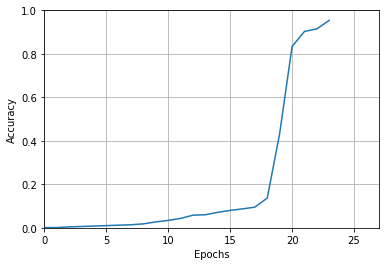

In [3]:
with open('output/ex1.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
         row = [float(j) for j in row]
    axes = plt.gca()
    axes.set_xlim([0,27])
    axes.set_ylim([0,1])
    plt.plot(row)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

### Experiment 2:
- Training data: 54000
- Validation data: 6000
- Testing data: 20000
- **digit: 4**

Result: At epoch 99, reach testing data accuracy = 0.91

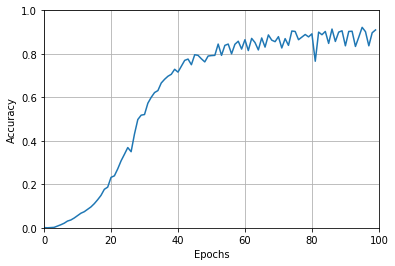

In [20]:
with open('output/ex2.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        row = [float(i) for i in row]
    axes = plt.gca()
    axes.set_xlim([0,100])
    axes.set_ylim([0,1])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(row)
    plt.grid()
    plt.show()

**Summary: 4-digit data takes more epochs to train**

## Compare different training / testing split(Exp3, Exp4)
### Experiment 3:
Training : Testing = 1 : 1
- Training data: 36000
- Validation data: 4000
- Testing data: 40000
- Digit: 3

Result: At epoch 34, reach testing data accuracy = 0.935

### Experiment 4:
Training : Testing = 1 : 3
- Training data: 18000
- Validation data: 2000
- Testing data: 60000
- Digit: 3

Result: At epoch 78, reach testing data accuracy = 0.933

**When training/testing proportion is smaller, it takes more epochs to reach the same accuracy.**

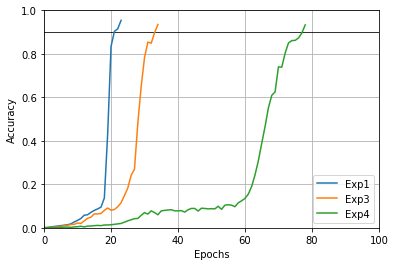

In [21]:
with open('output/ex1.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
         row1 = [float(j) for j in row]
with open('output/ex3.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        row3 = [float(i) for i in row]
with open('output/ex4.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        row4 = [float(i) for i in row]

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,1])
axes.axhline(y=0.9, color='black', linewidth=0.8)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(row1, label='Exp1')
plt.plot(row3, label='Exp3')
plt.plot(row4, label='Exp4')
plt.grid()
plt.legend()
plt.show()

We can see from the above chart that in the 3-digit training, the accuracy always **increases from about 0.1 to 0.9 in no more than 10 epochs**.<br>
So I think if I make it start from a better weights and biases, or using some other methods, maybe the training epochs can decrease.

## Reference

[從零開始的 Sequence to Sequence](http://zake7749.github.io/2017/09/28/Sequence-to-Sequence-tutorial/)<br>
[如何在長短期記憶(LSTM)網絡中利用TimeDistributed層——python語言](https://kknews.cc/zh-tw/tech/y62kj5k.html)<br>
[如何為LSTM重新構建輸入資料（Keras）](http://toments.com/179540/)<br>
[Understanding Input and Output shapes in LSTM | Keras](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e)<br>
[利用Keras建構LSTM模型，以Stock Prediction 為例 1](https://medium.com/@daniel820710/%E5%88%A9%E7%94%A8keras%E5%BB%BA%E6%A7%8Blstm%E6%A8%A1%E5%9E%8B-%E4%BB%A5stock-prediction-%E7%82%BA%E4%BE%8B-1-67456e0a0b)<br>
[A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)<br>
[addition_rnn.py | Github](https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py)<br>
[Many to one and many to many LSTM examples in Keras](https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras)<br>
[使用 Keras 实现简单的 Sequence to Sequence 模型](http://www.zmonster.me/2016/05/29/sequence_to_sequence_with_keras.html)<br>